In [1]:
# Third-party and Standard Libraries
from datetime import datetime
import numpy as np
import scipy.io
import torch
import time
import os
import matplotlib.pyplot as plt
# Modules
from AC_precompute import inputs, gram_schmidt1_double, gram_schmidt2_double
from AC_test_adam import gpt_test, gpt_test_loss,gpt_test_loss_c
from AC_GPT_train import offline_generation,offline_generation_GD
from AC_SA_PINN import NN
from AC_SA_train import sa_pinn_train
from AC_models import P
from pyDOE import lhs


data_dir = "./ac_data/"
if (os.path.exists(data_dir) == False):
    os.makedirs(data_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Force CUDA initialization
dummy = torch.tensor([0.0]).to(device)

print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

#device = torch.device("cuda")
print_seperator = 60*"*"

sparse = False

if (sparse):
    ext = "s"
else:
    ext = ""

print(f"Start: {datetime.now()}\n")

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB
Start: 2025-01-04 02:10:28.387312



In [2]:
#### Domain and simulated data ####
N0  = 512
N_b = 100
N_f = 20000

data = scipy.io.loadmat('/dssg/home/acct-matxzl/matxzl/Yajie/GPT_PINN3/Sparse_GPT-PINN/Allen Cahn/AC.mat')
t = data['tt'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact_u = data['uu']

#### SA-PINN ####
# IC (Initial Condition)
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x, :]
u0 = torch.tensor(Exact_u[idx_x, 0:1], dtype=torch.float32).to(device)
X0 = np.concatenate((x0, 0 * x0), 1)
x0 = torch.tensor(X0[:, 0:1], dtype=torch.float32).to(device)
t0 = torch.tensor(X0[:, 1:2], dtype=torch.float32).to(device)

# BC (Boundary Condition)
lb = np.array([-1.0]) 
ub = np.array([1.0])

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t, :]

X_lb = np.concatenate((0 * tb + lb[0], tb), 1)
X_ub = np.concatenate((0 * tb + ub[0], tb), 1)
x_lb = torch.tensor(X_lb[:, 0:1], dtype=torch.float32).to(device)
t_lb = torch.tensor(X_lb[:, 1:2], dtype=torch.float32).to(device)
x_ub = torch.tensor(X_ub[:, 0:1], dtype=torch.float32).to(device)
t_ub = torch.tensor(X_ub[:, 1:2], dtype=torch.float32).to(device)

# Collocation Points
X_f = lb + (ub - lb) * lhs(2, N_f)
x_f = torch.tensor(X_f[:, 0:1], dtype=torch.float32).to(device)
t_f = torch.tensor(np.abs(X_f[:, 1:2]), dtype=torch.float32).to(device)

#### GPT ####
# IC (Initial Condition)
val, idx = torch.sort(torch.tensor(X0[:, 0:1].flatten()))
IC_u = torch.tensor(Exact_u[idx_x, 0:1], dtype=torch.float32)[idx].to(device)

IC_xt = torch.hstack((torch.tensor(X0[idx, 0:1], dtype=torch.float32), 
                      torch.tensor(X0[:, 1:2], dtype=torch.float32))).to(device)

# BC (Boundary Condition)
x_lb_py = torch.tensor(X_lb[:, 0:1], dtype=torch.float32).to(device)
t_lb_py = torch.tensor(X_lb[:, 1:2], dtype=torch.float32).to(device)
x_ub_py = torch.tensor(X_ub[:, 0:1], dtype=torch.float32).to(device)
t_ub_py = torch.tensor(X_ub[:, 1:2], dtype=torch.float32).to(device)

BC_xt_ub = torch.hstack((x_ub_py, t_ub_py)).to(device).requires_grad_()
BC_xt_lb = torch.hstack((x_lb_py, t_lb_py)).to(device).requires_grad_()

# Collocation Points
xt_resid = torch.hstack((torch.tensor(X_f[:, 0:1], dtype=torch.float32), 
                         torch.tensor(np.abs(X_f[:, 1:2]), dtype=torch.float32))).to(device).requires_grad_()
f_hat = torch.zeros(20000, 1).to(device)

# Test Data
x_test, t_test = torch.meshgrid(torch.linspace(-1, 1, 100),
                                torch.linspace(0, 1, 100), indexing="ij")

xt_test = torch.hstack((x_test.transpose(1, 0).flatten().unsqueeze(1), 
                        t_test.transpose(1, 0).flatten().unsqueeze(1))).to(device)

#### Training parameter set ####
Lmbda        = np.linspace(1e-3,1e-4,11)
Eps          = np.linspace(1,5,11)
ac_train     = np.array(np.meshgrid(Lmbda, Eps)).T.reshape(-1,2)
ac_train_all = ac_train.copy() 

#### SA-PINN attributes ####
lr_adam_sa  = 0.001
lr_weights  = 0.001
lr_lbfgs_sa = 0.1
tol_adam    = 1e-3

epochs_adam_sa  = 50000
epochs_lbfgs_sa = 1000

layers_pinn = [2, 128, 128, 128, 128, 1]

In [3]:
#### GPT-PINN attributes ####
number_of_neurons = 12
if (sparse):
    lr_gpt = 0.01
else:   
    lr_gpt = 0.0025
epochs_gpt_train  = 2000

test_cases      = np.ceil(0.2*len(ac_train)).astype(int)
epochs_gpt_test = 2000

loss_list  = np.zeros(number_of_neurons)
loss_list1  = np.zeros(number_of_neurons)
neurons    = np.zeros((number_of_neurons,2))
neurons0    = np.zeros((number_of_neurons,2))

# Two kinds of initializations for the neurons
neurons[0] = (np.median(Lmbda), np.median(Eps))
neurons[0] = (0.001, 1.0)
neurons0[0] = (0.001, 1.0)
#neurond[0] = ac_train[np.random.randint(low=0, high=len(ac_train))]

c_init = np.zeros(number_of_neurons, dtype=object)
for i in range(number_of_neurons):
    c_init[i] = torch.full((1,i+1), 1/(i+1)).to(device)
    
#### Data sizes ####
test_size = xt_test.shape[0]
xt_size   = xt_resid.shape[0]
IC_size   = IC_xt.shape[0]
BC_size   = BC_xt_ub.shape[0]    

if (sparse):
    #### Training point data ####
    X_train_all   = torch.zeros((2*number_of_neurons-1,2)).to(device)
    X_all_idx     = torch.zeros( 2*number_of_neurons-1, dtype=torch.long).to(device)
    X_umax_idx    = torch.zeros(   number_of_neurons,   dtype=torch.long).to(device)
    X_rmax_idx    = torch.zeros(   number_of_neurons-1, dtype=torch.long).to(device)
    residual_full = torch.zeros((xt_size, number_of_neurons-1), dtype=torch.float32).to(device)

#### Neuron outputs on the full training grid ####
out_full    = torch.zeros((xt_size, number_of_neurons), dtype=torch.float32).to(device)
out_t_full  = torch.zeros((xt_size, number_of_neurons), dtype=torch.float32).to(device)
out_xx_full = torch.zeros((xt_size, number_of_neurons), dtype=torch.float32).to(device)
out_IC      = torch.zeros((IC_size, number_of_neurons), dtype=torch.float32).to(device)

out_BC_ub   = torch.zeros((BC_size, number_of_neurons), dtype=torch.float32).to(device)
out_BC_lb   = torch.zeros((BC_size, number_of_neurons), dtype=torch.float32).to(device)
out_BC_diff = torch.zeros((BC_size, number_of_neurons), dtype=torch.float32).to(device)

out_BC_ub_x   = torch.zeros((BC_size, number_of_neurons), dtype=torch.float32).to(device)
out_BC_lb_x   = torch.zeros((BC_size, number_of_neurons), dtype=torch.float32).to(device)
out_BC_diff_x = torch.zeros((BC_size, number_of_neurons), dtype=torch.float32).to(device)

#### Neuron outputs on the full training grid ####
out_test    = torch.zeros((test_size, number_of_neurons), dtype=torch.float32).to(device) 

In [4]:
plot_test=True
if plot_test:
    lmbda1 = 0.0002
    eps1 = 1.8
    PINN1 = NN(layers_pinn, lmbda1,eps1).to(device)
    pinn_losses = sa_pinn_train(PINN1, lr_adam_sa, lr_weights, lr_lbfgs_sa, epochs_adam_sa, epochs_lbfgs_sa, tol_adam, xt_resid, f_hat, IC_xt, IC_u, BC_xt_ub, BC_xt_lb)

    lmbda2 = 0.0009
    eps2 = 3.8
    PINN2 = NN(layers_pinn, lmbda2,eps2).to(device)
    pinn_losses = sa_pinn_train(PINN2, lr_adam_sa, lr_weights, lr_lbfgs_sa, epochs_adam_sa, epochs_lbfgs_sa, tol_adam, xt_resid, f_hat, IC_xt, IC_u, BC_xt_ub, BC_xt_lb)

/dssg/home/acct-matxzl/matxzl/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 3649 | Loss: 0.0009958280716091394 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 55 | Loss: 9.784995199879631e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

Epoch: 10000 | loss: 0.004648854956030846 	 ep time: 0.004768808372318745
Epoch: 12828 | Loss: 0.0009904273319989443 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 267 | Loss: 9.95293230516836e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!



************************************************************
Epoch: 1988 | Loss: 0.000998439616523683 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 39 | Loss: 9.659575880505145e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 0.481792143980662 minutes

Generation time: 0.481792143980662 minutes
Parameter Case: [1.e-04 5.e+00]


Largest Loss (Using 1 Neurons): 0.4707409143447876


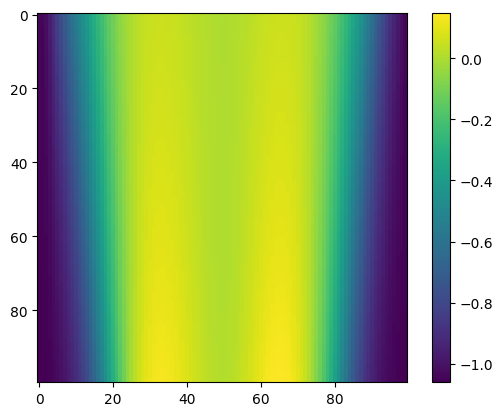

Activation Function Parameters: 
[[1.e-03 1.e+00]
 [1.e-04 5.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]]

Loss list: (array([0.47074091, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))



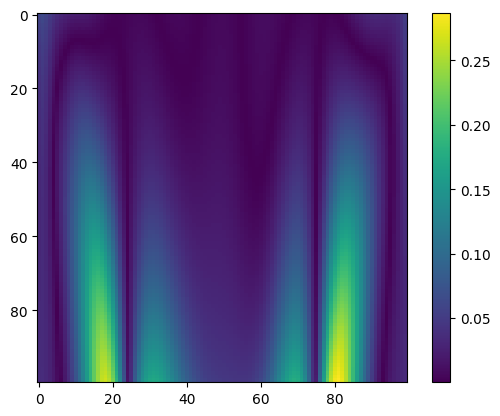

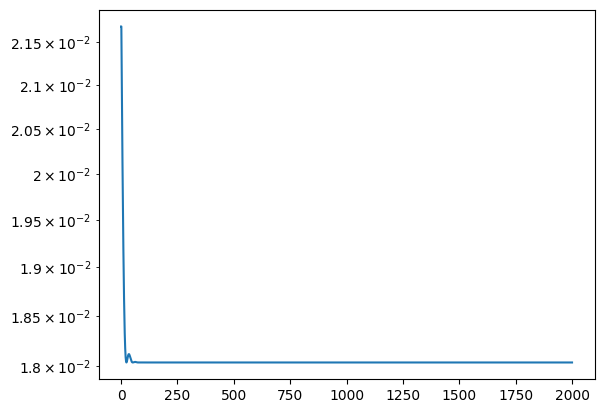

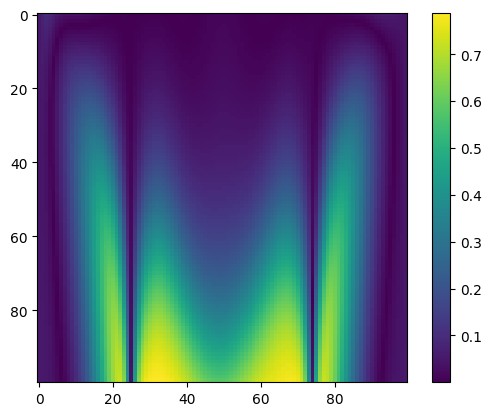

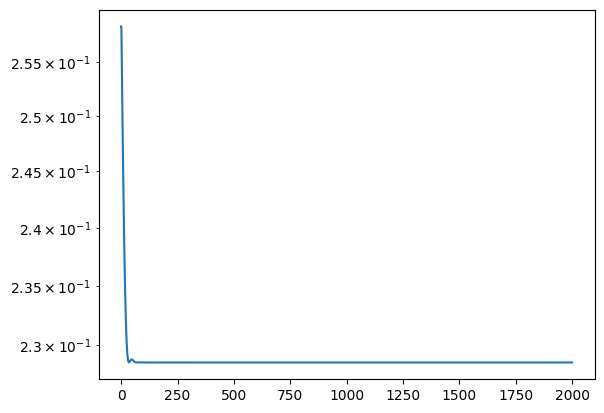

************************************************************
Epoch: 10000 | loss: 0.13684022426605225 	 ep time: 0.004810764454305172
Epoch: 20000 | loss: 0.01490375678986311 	 ep time: 0.004786510951817036
Epoch: 28449 | Loss: 0.0009927550563588738 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 379 | Loss: 9.878273704089224e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 6.007882944742838 minutes

Generation time: 6.007882944742838 minutes
Parameter Case: [1.e-03 3.e+00]


Largest Loss (Using 2 Neurons): 0.11204610019922256


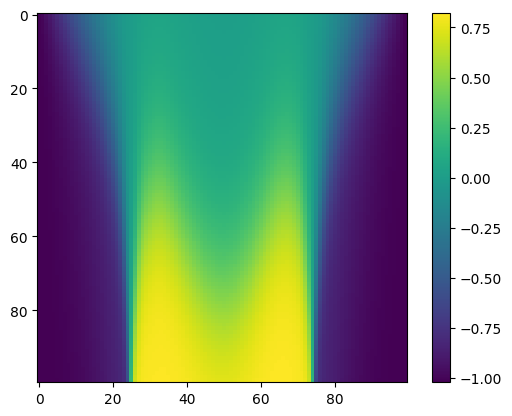

Activation Function Parameters: 
[[1.e-03 1.e+00]
 [1.e-04 5.e+00]
 [1.e-03 3.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]
 [0.e+00 0.e+00]]

Loss list: (array([0.47074091, 0.1120461 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))



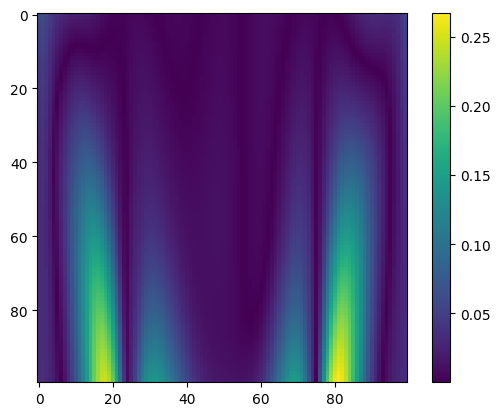

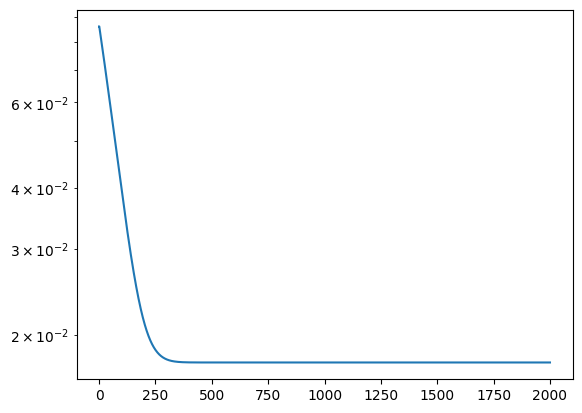

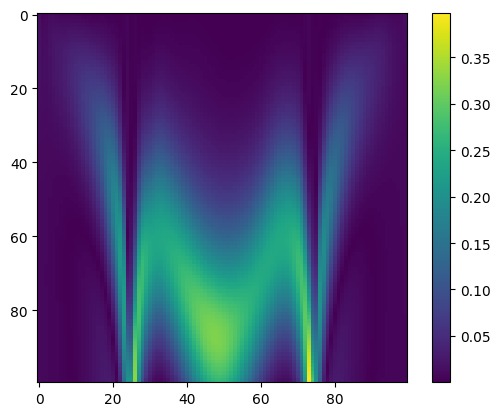

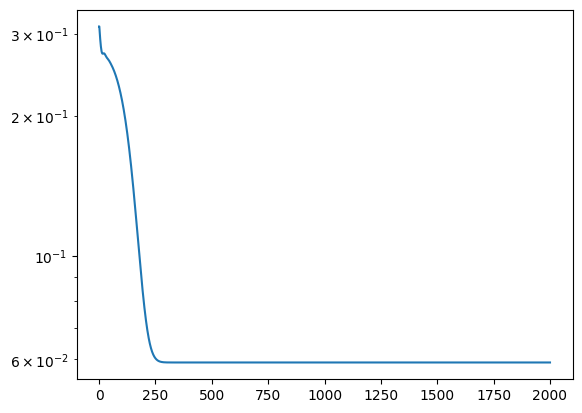

************************************************************
Epoch: 7084 | Loss: 0.0009992575505748391 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 80 | Loss: 9.968953963834792e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 1.3989811579386393 minutes

Generation time: 1.3989811579386393 minutes
Parameter Case: [1.0e-03 4.2e+00]


Largest Loss (Using 3 Neurons): 0.02869395725429058


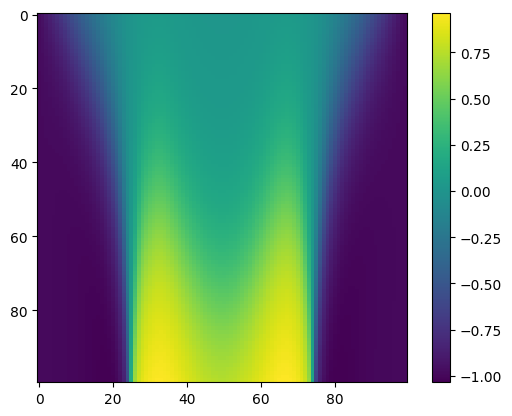

Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-04 5.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-03 4.2e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([0.47074091, 0.1120461 , 0.02869396, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))



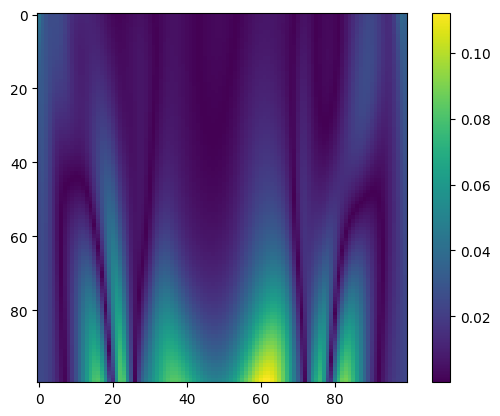

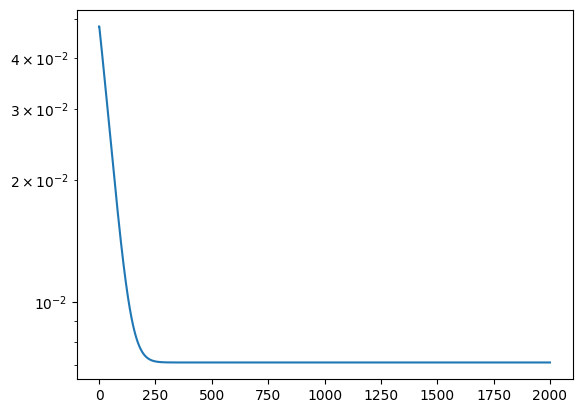

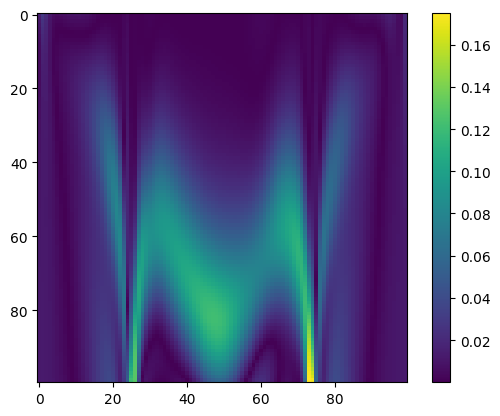

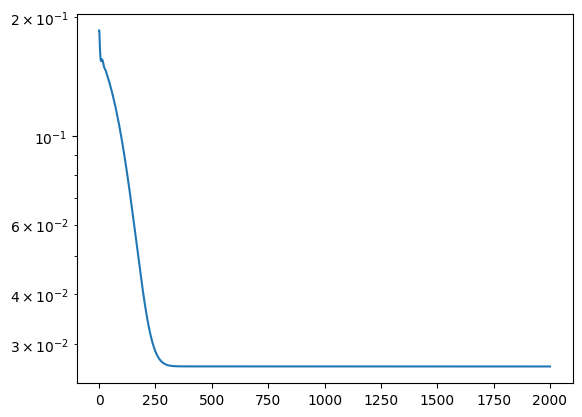

************************************************************
Epoch: 10000 | loss: 0.16194407641887665 	 ep time: 0.0047904206439852715
Epoch: 20000 | loss: 0.007449566386640072 	 ep time: 0.0047851139679551125
Epoch: 20898 | Loss: 0.0009978589368984103 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 309 | Loss: 9.964803030015901e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 4.474433024724324 minutes

Generation time: 4.474433024724324 minutes
Parameter Case: [1.e-03 5.e+00]


Largest Loss (Using 4 Neurons): 0.016753192991018295


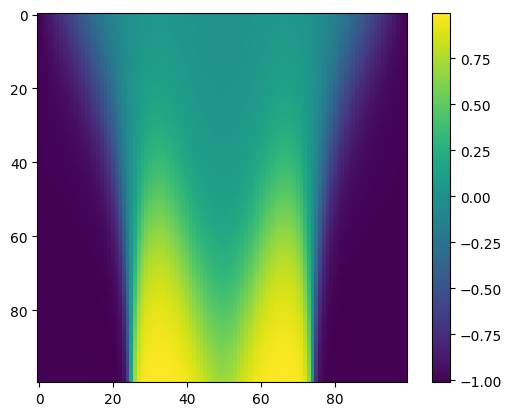

Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-04 5.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-03 4.2e+00]
 [1.0e-03 5.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([0.47074091, 0.1120461 , 0.02869396, 0.01675319, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))



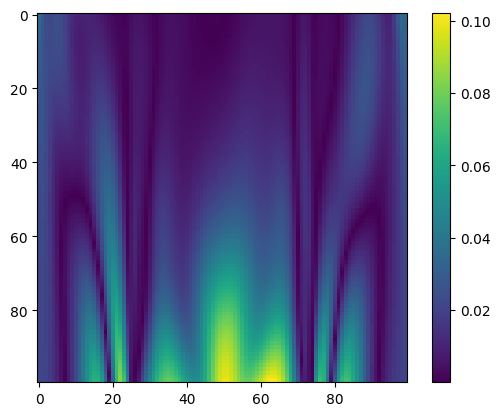

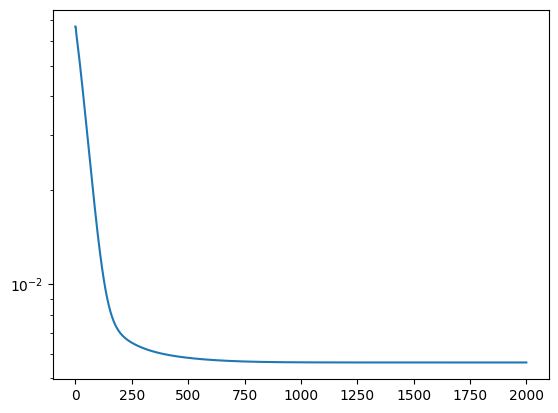

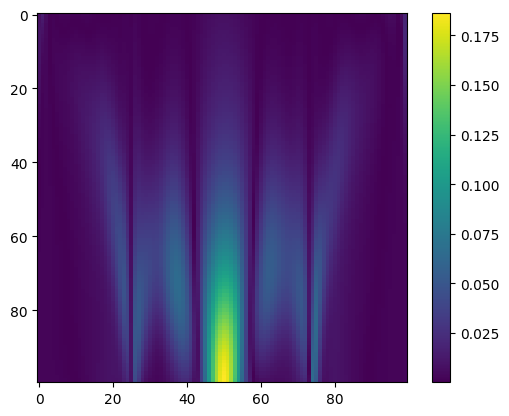

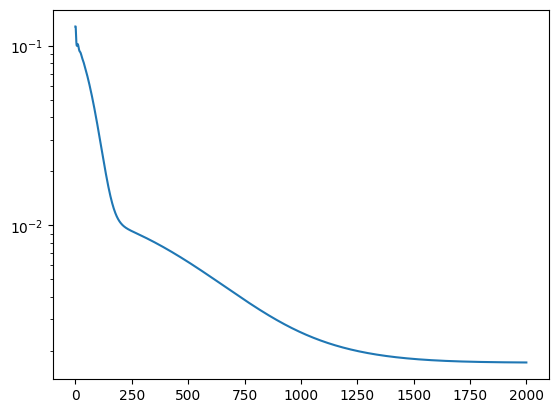

************************************************************
Epoch: 10000 | loss: 0.13742965459823608 	 ep time: 0.004784454591572285
Epoch: 20000 | loss: 0.15153740346431732 	 ep time: 0.004777614027261734
Epoch: 30000 | loss: 0.0019586491398513317 	 ep time: 0.004789687693119049
Epoch: 37474 | Loss: 0.0009427667828276753 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 400 | loss: 0.00011506550072226673
Epoch: 431 | Loss: 9.941888856701553e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 7.51233549118042 minutes

Generation time: 7.51233549118042 minutes
Parameter Case: [1.e-04 3.e+00]


Largest Loss (Using 5 Neurons): 0.014143556356430054


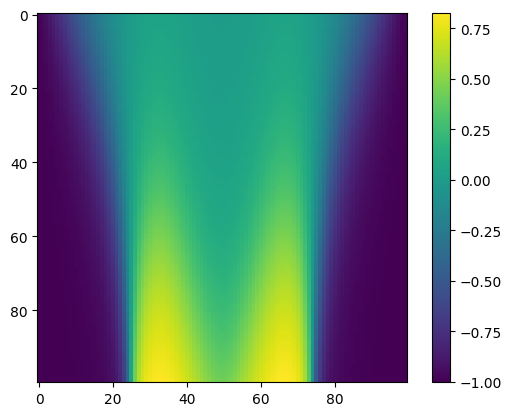

Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-04 5.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-03 4.2e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([0.47074091, 0.1120461 , 0.02869396, 0.01675319, 0.01414356,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))



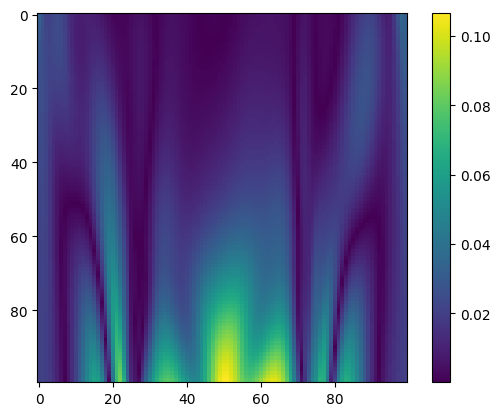

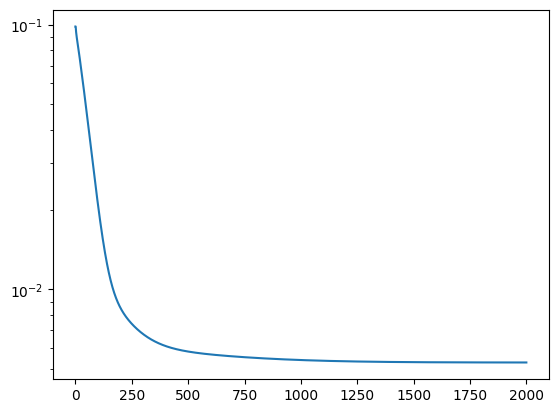

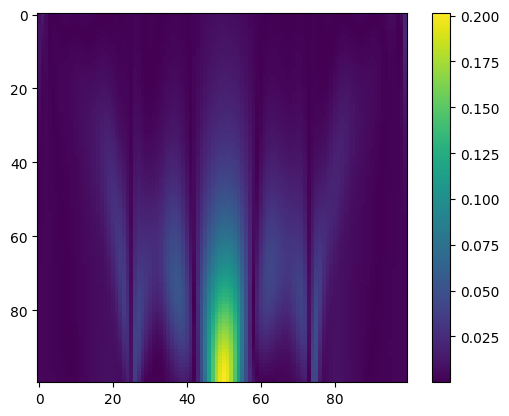

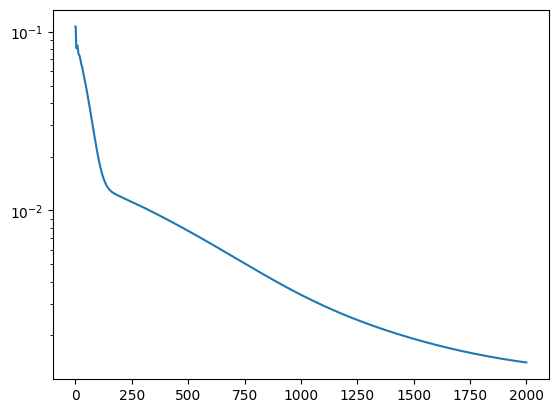

************************************************************
Epoch: 6515 | Loss: 0.0009940934833139181 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 119 | Loss: 9.864042658591643e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 1.544445017973582 minutes

Generation time: 1.544445017973582 minutes
Parameter Case: [1.0e-04 3.8e+00]


Largest Loss (Using 6 Neurons): 0.011151599697768688


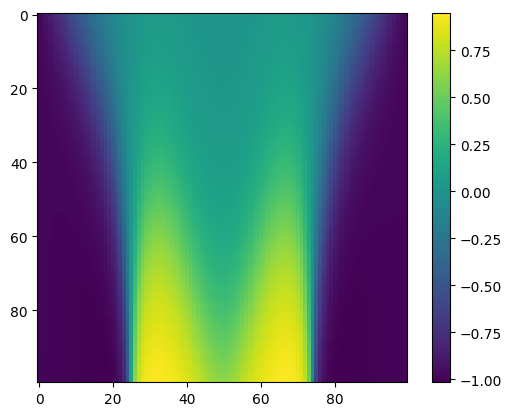

Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-04 5.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-03 4.2e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.0e+00]
 [1.0e-04 3.8e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([0.47074091, 0.1120461 , 0.02869396, 0.01675319, 0.01414356,
       0.0111516 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))



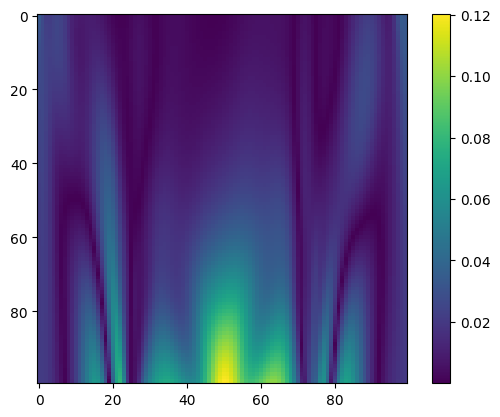

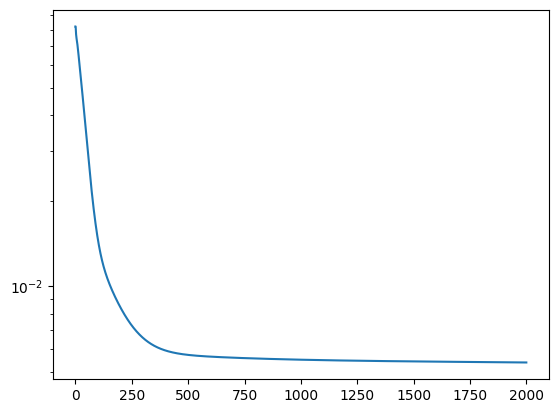

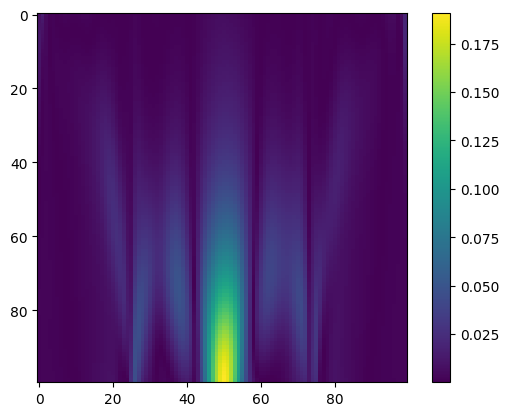

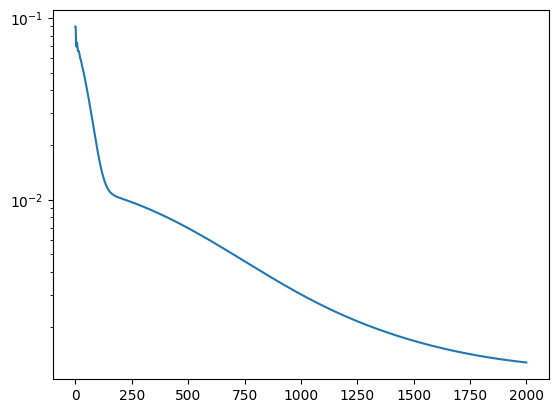

************************************************************
Epoch: 10000 | loss: 0.002788892015814781 	 ep time: 0.004809821955859661
Epoch: 13076 | Loss: 0.0009850480128079653 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 205 | Loss: 9.942391625372693e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 2.91321945587794 minutes

Generation time: 2.91321945587794 minutes
Parameter Case: [1.e-04 1.e+00]


Largest Loss (Using 7 Neurons): 0.010471859015524387


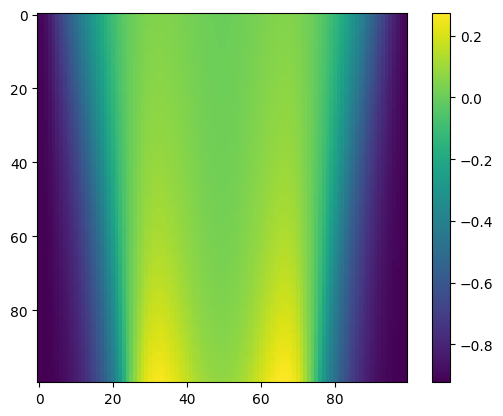

Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-04 5.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-03 4.2e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 1.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([0.47074091, 0.1120461 , 0.02869396, 0.01675319, 0.01414356,
       0.0111516 , 0.01047186, 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))



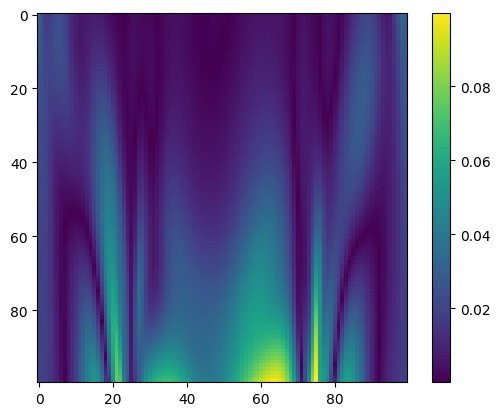

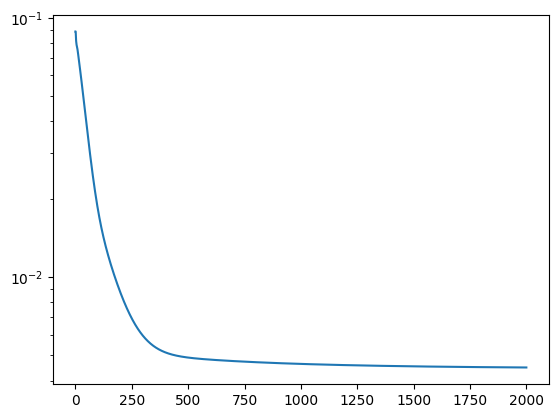

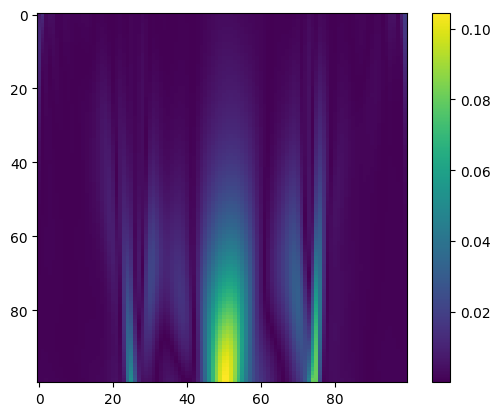

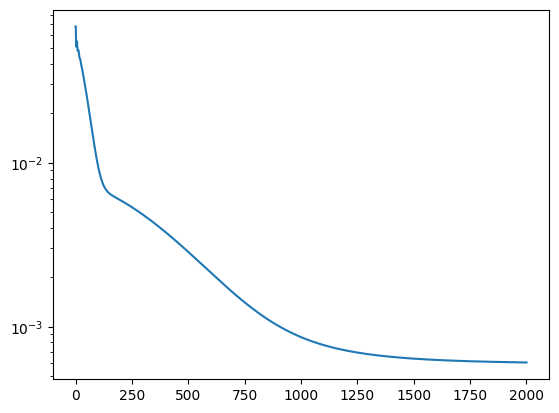

************************************************************
Epoch: 2571 | Loss: 0.000980430282652378 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 43 | Loss: 9.70451656030491e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 0.5851420958836874 minutes

Generation time: 0.5851420958836874 minutes
Parameter Case: [1.0e-04 2.2e+00]


Largest Loss (Using 8 Neurons): 0.010255543515086174


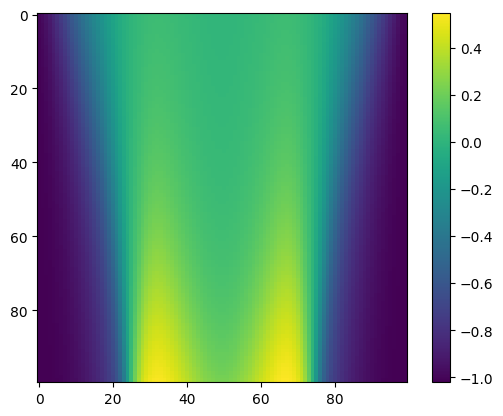

Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-04 5.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-03 4.2e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 1.0e+00]
 [1.0e-04 2.2e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([0.47074091, 0.1120461 , 0.02869396, 0.01675319, 0.01414356,
       0.0111516 , 0.01047186, 0.01025554, 0.        , 0.        ,
       0.        , 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))



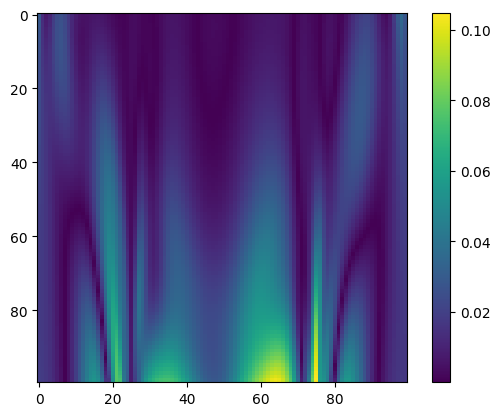

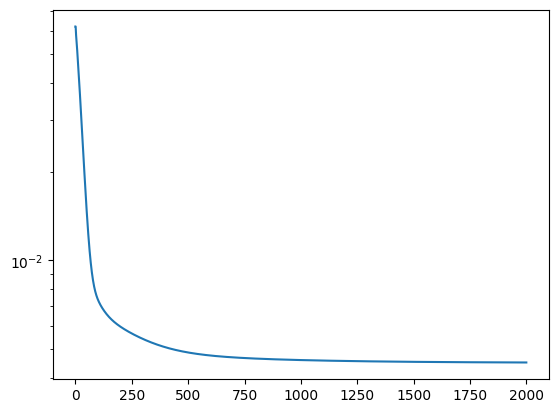

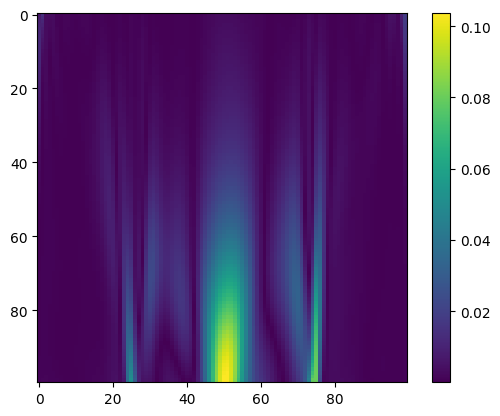

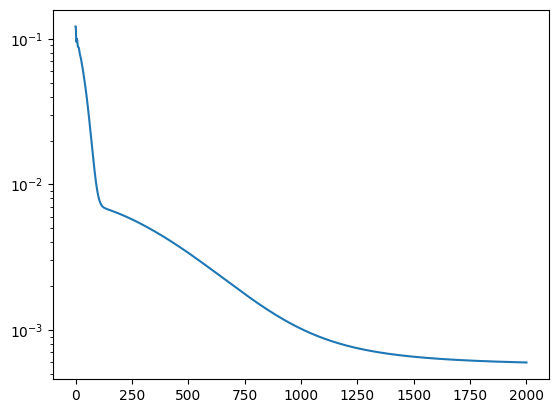

************************************************************
Epoch: 5214 | Loss: 0.00099978968501091 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 56 | Loss: 9.980861796066165e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 1.0198338031768799 minutes

Generation time: 1.0198338031768799 minutes
Parameter Case: [1.9e-04 5.0e+00]


Largest Loss (Using 9 Neurons): 0.007940420880913734


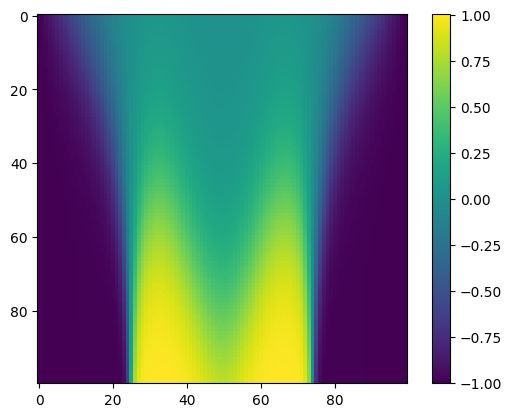

Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-04 5.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-03 4.2e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 1.0e+00]
 [1.0e-04 2.2e+00]
 [1.9e-04 5.0e+00]
 [0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([0.47074091, 0.1120461 , 0.02869396, 0.01675319, 0.01414356,
       0.0111516 , 0.01047186, 0.01025554, 0.00794042, 0.        ,
       0.        , 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))



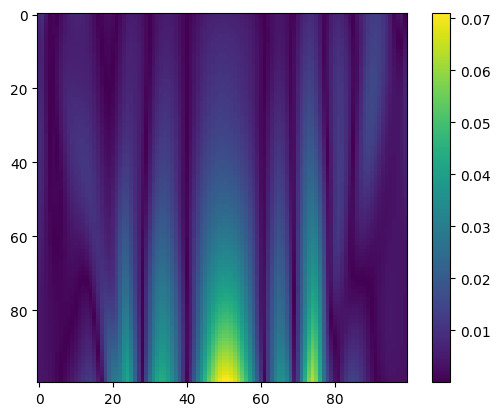

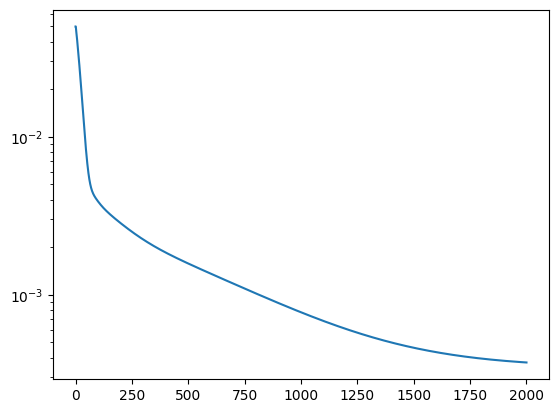

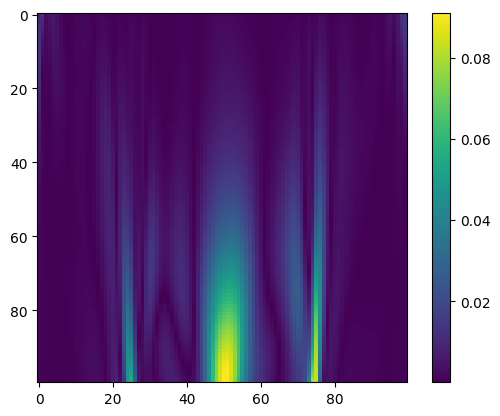

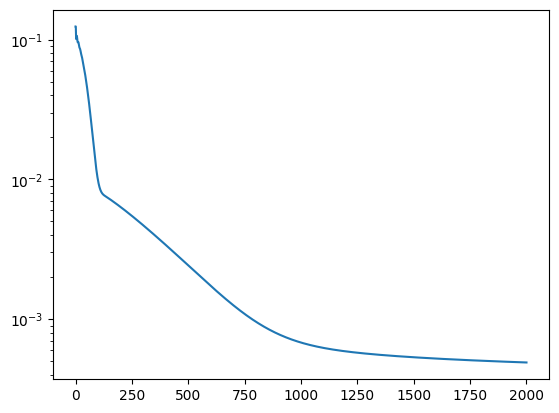

************************************************************
Epoch: 10000 | loss: 0.14186398684978485 	 ep time: 0.004800320602953434
Epoch: 20000 | loss: 0.971944272518158 	 ep time: 0.004795413464307785
Epoch: 27958 | Loss: 0.0009900154545903206 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 400 | loss: 0.00023470434825867414
Epoch: 579 | Loss: 9.926663187798113e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 6.964615980784099 minutes

Generation time: 6.964615980784099 minutes
Parameter Case: [1.9e-04 3.8e+00]


Largest Loss (Using 10 Neurons): 0.006099950522184372


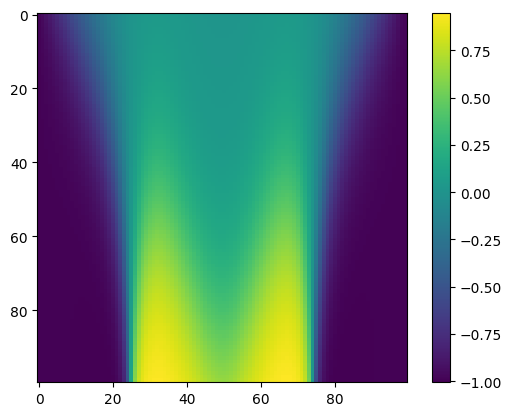

Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-04 5.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-03 4.2e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 1.0e+00]
 [1.0e-04 2.2e+00]
 [1.9e-04 5.0e+00]
 [1.9e-04 3.8e+00]
 [0.0e+00 0.0e+00]]

Loss list: (array([0.47074091, 0.1120461 , 0.02869396, 0.01675319, 0.01414356,
       0.0111516 , 0.01047186, 0.01025554, 0.00794042, 0.00609995,
       0.        , 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))



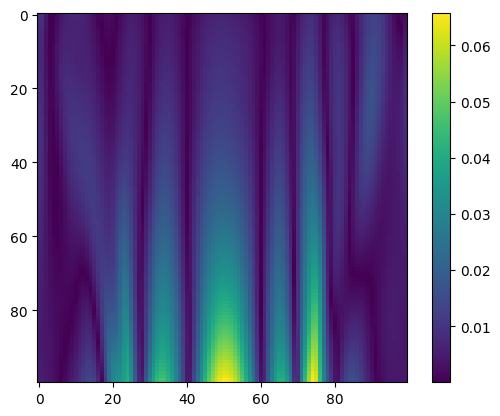

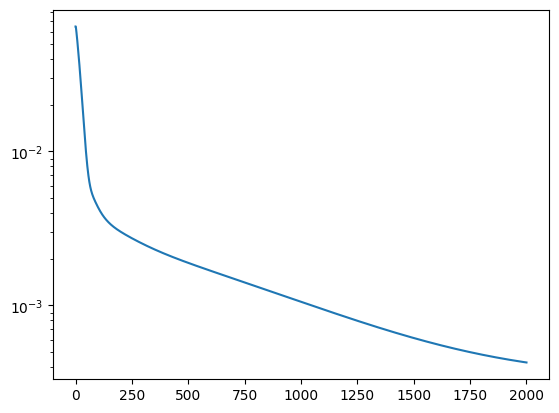

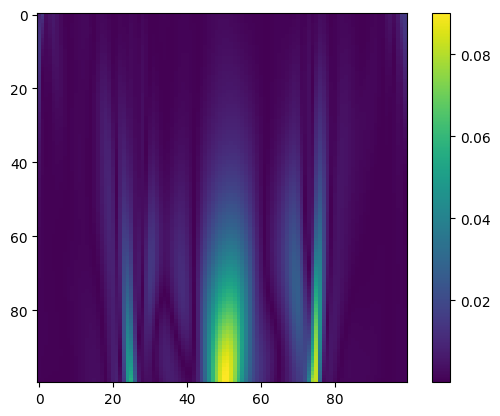

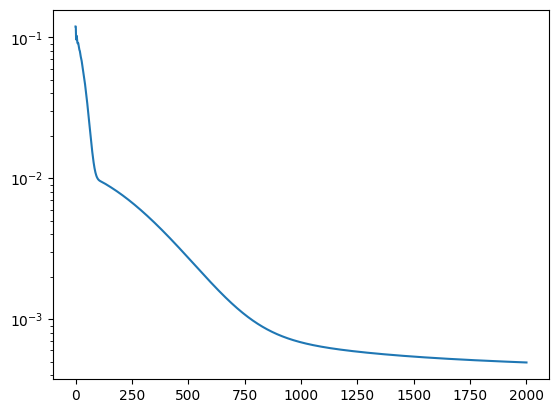

************************************************************
Epoch: 9903 | Loss: 0.000977488816715777 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 171 | Loss: 9.774002683116123e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 2.294036265214284 minutes

Generation time: 2.294036265214284 minutes
Parameter Case: [1.9e-04 2.2e+00]


Largest Loss (Using 11 Neurons): 0.0058744484558701515


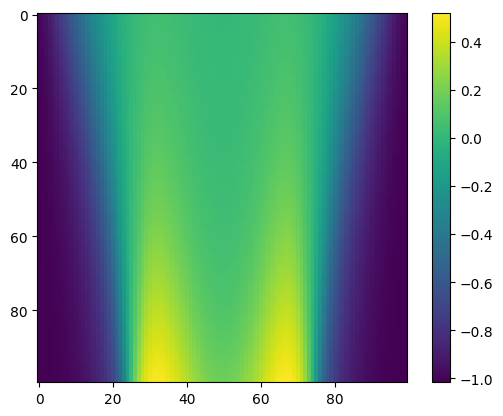

Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-04 5.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-03 4.2e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 1.0e+00]
 [1.0e-04 2.2e+00]
 [1.9e-04 5.0e+00]
 [1.9e-04 3.8e+00]
 [1.9e-04 2.2e+00]]

Loss list: (array([0.47074091, 0.1120461 , 0.02869396, 0.01675319, 0.01414356,
       0.0111516 , 0.01047186, 0.01025554, 0.00794042, 0.00609995,
       0.00587445, 0.        ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))



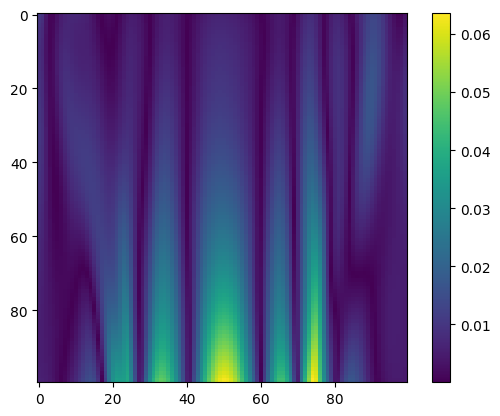

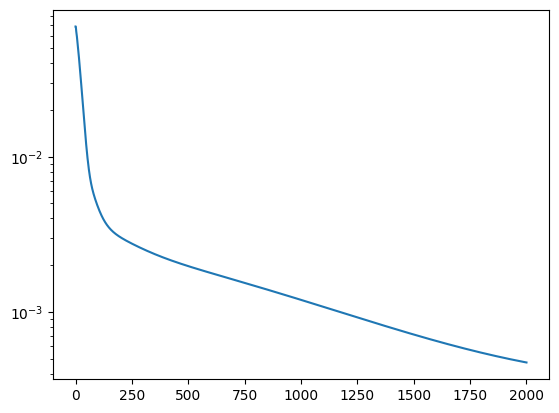

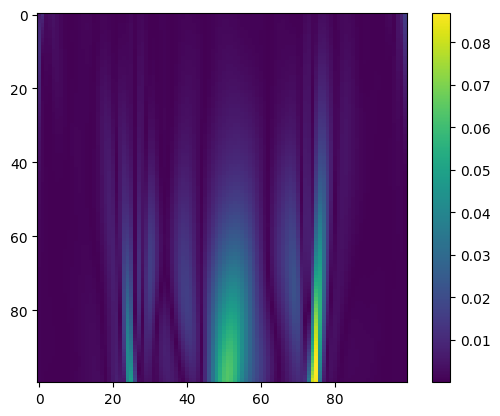

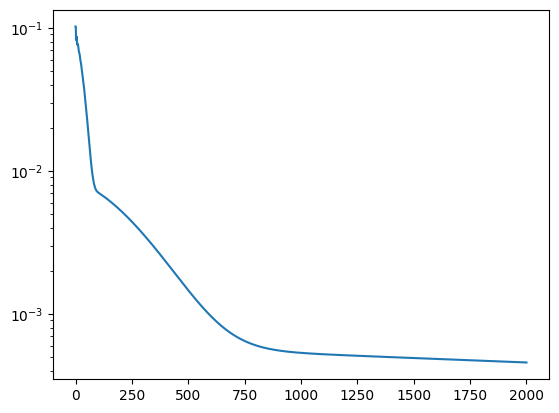

************************************************************
Epoch: 4583 | Loss: 0.0009917340939864516 (Stopping Criteria Met)
SA-PINN Adam training completed!

Begin L-BFGS training!
Epoch: 55 | Loss: 9.854726522462443e-05 (Stopping Criteria Met)
SA-PINN LBFGS training completed!

PINN time: 0.921458121140798 minutes

Generation time: 0.921458121140798 minutes

Largest Loss (Using 12 Neurons): 0.005697216372936964


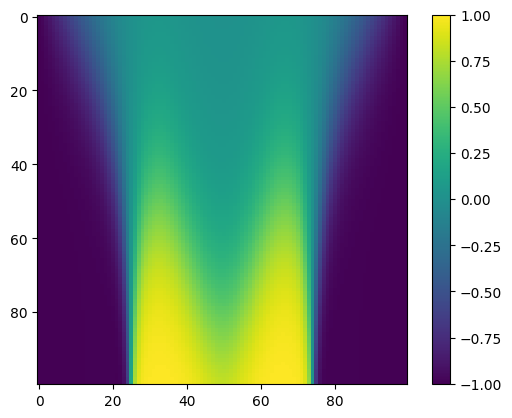

************************************************************
Total Training Time: 0.8094880755742391 Hours

Activation Function Parameters: 
[[1.0e-03 1.0e+00]
 [1.0e-04 5.0e+00]
 [1.0e-03 3.0e+00]
 [1.0e-03 4.2e+00]
 [1.0e-03 5.0e+00]
 [1.0e-04 3.0e+00]
 [1.0e-04 3.8e+00]
 [1.0e-04 1.0e+00]
 [1.0e-04 2.2e+00]
 [1.9e-04 5.0e+00]
 [1.9e-04 3.8e+00]
 [1.9e-04 2.2e+00]]

Loss list: [0.47074091 0.1120461  0.02869396 0.01675319 0.01414356 0.0111516
 0.01047186 0.01025554 0.00794042 0.00609995 0.00587445 0.00569722]



In [6]:
generation_time = np.zeros(number_of_neurons)
###############################################################################
total_time_1 = time.time()
for i, neuron in enumerate(neurons):
    print(print_seperator)
    
    # Don't need to train over parameters already used as neurons
    ac_train = np.delete(ac_train, np.where(np.all(ac_train == neuron, 
                                                   axis=1))[0], axis=0)    
    ###########################################################################
    # SA-PINN to be used as activation function
    lmbda, eps = neuron
    
    t1 = time.time()
    PINN = NN(layers_pinn, lmbda, eps).to(device)
    sa_pinn_train(PINN, lr_adam_sa, lr_weights, lr_lbfgs_sa, epochs_adam_sa, epochs_lbfgs_sa, tol_adam, xt_resid, f_hat, IC_xt, IC_u, 
                     BC_xt_ub, BC_xt_lb)
    t2 = time.time()
    print(f"PINN time: {(t2-t1)/60} minutes\n")
    #plt.imshow(PINN(xt_test).reshape(60,60).detach().cpu().numpy())
    ###########################################################################    
    # (S)GPT-PINN Training / Offline Generation
    c_initial  = c_init[i][0]
            
    if (sparse): # SGPT
        train_out, train_out_xx, train_out_t, train_out_IC, train_out_BC_ub, \
        train_out_BC_lb, train_out_BC_diff, fhat, train_len, train_out_BC_ub_x,\
        train_out_BC_lb_x, train_out_BC_diff_x,ALPHA = gram_schmidt1_double(PINN, i, xt_resid, 
        IC_xt, BC_xt_ub, BC_xt_lb, out_full, out_xx_full, out_t_full, out_IC, 
        out_BC_ub, out_BC_lb, X_umax_idx, X_all_idx, X_train_all, xt_test, 
        out_test, f_hat, out_BC_diff, out_BC_ub_x, out_BC_lb_x, out_BC_diff_x)  
        if i==0:
            c_ui           = PINN(xt_resid)
            c_x_umax_idx = torch.argmax(torch.abs(c_ui))
            if c_ui[c_x_umax_idx]<0:
                c_initial[i] = -1.0
        else:
            c_initial[:i] = ALPHA.squeeze()
            c_initial[i] = 0.0

        largest_loss, largest_case, trained_c = offline_generation(ac_train, c_initial, 
        train_len, IC_size, BC_size, IC_u, train_out, train_out_t, train_out_xx, 
        train_out_IC, train_out_BC_ub, train_out_BC_lb, train_out_BC_diff, 
        train_out_BC_ub_x, train_out_BC_lb_x, train_out_BC_diff_x, fhat, 
        epochs_gpt_train, lr_gpt)

    else: # GPT
        train_out, train_out_xx, train_out_t, train_out_IC, train_out_BC_ub, \
        train_out_BC_lb, train_out_BC_diff, fhat, train_len, train_out_BC_ub_x,\
        train_out_BC_lb_x, train_out_BC_diff_x = inputs(PINN, xt_resid, out_full, 
        out_xx_full, out_t_full, out_IC, out_BC_ub, out_BC_lb, IC_xt, BC_xt_ub, 
        BC_xt_lb, i, out_test, xt_test, f_hat, xt_size, out_BC_diff, out_BC_ub_x, 
        out_BC_lb_x, out_BC_diff_x)

        largest_loss, largest_case, trained_c = offline_generation_GD(ac_train, c_initial, 
        train_len, IC_size, BC_size, IC_u, train_out, train_out_t, train_out_xx, 
        train_out_IC, train_out_BC_ub, train_out_BC_lb, train_out_BC_diff, 
        train_out_BC_ub_x, train_out_BC_lb_x, train_out_BC_diff_x, fhat, 
        epochs_gpt_train, lr_gpt)

    generation_time[i] = (t2-t1)/60
    print(f"Generation time: {(t2-t1)/60} minutes")  
    
    ###########################################################################
    loss_list[i] = largest_loss
    if (i+1 < number_of_neurons):
        neurons[i+1] = largest_case
        neurons0[i+1] = (np.random.choice(Lmbda),np.random.choice(Eps))
        print(f"Parameter Case: {neurons[i+1]}\n")
    print(f"\nLargest Loss (Using {i+1} Neurons): {largest_loss}")
    plt.imshow(((out_test[:,:i+1]@trained_c)).reshape(100,100).detach().cpu().numpy())
    plt.colorbar()
    plt.show()
    if (i == number_of_neurons-1):
        break
    
    ###########################################################################
    
    if (sparse):
        lmbda, eps = largest_case
        gram_schmidt2_double(i, xt_resid, lmbda, eps, trained_c, residual_full, out_full, 
                      out_xx_full, out_t_full, X_rmax_idx, X_all_idx, X_train_all)
                     
    print(f"Activation Function Parameters: \n{neurons}\n")
    #print(f"Activation Function Parameters: \n{neurons0}\n")
    print(f"Loss list: {loss_list,loss_list1}\n")
    
    if plot_test:
        losses1,trained_c1 = gpt_test_loss_c([[lmbda1,eps1]], train_out, train_out_t, train_out_xx, 
                                        train_out_IC, fhat, train_len, IC_size, BC_size, IC_u, c_initial, epochs_gpt_test, 
                                        lr_gpt, out_test, train_out_BC_ub, train_out_BC_lb, train_out_BC_diff,      
                                        train_out_BC_ub_x, train_out_BC_lb_x, train_out_BC_diff_x)
        plt.imshow((abs(PINN1(xt_test).view(-1)-out_test[:,:i+1]@trained_c1)).reshape(100,100).detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        plt.plot(losses1)
        plt.yscale('log')
        plt.show()
        losses2,trained_c2 = gpt_test_loss_c([[lmbda2,eps2]], train_out, train_out_t, train_out_xx, 
                                        train_out_IC, fhat, train_len, IC_size, BC_size, IC_u, c_initial, epochs_gpt_test, 
                                        lr_gpt, out_test, train_out_BC_ub, train_out_BC_lb, train_out_BC_diff,      
                                        train_out_BC_ub_x, train_out_BC_lb_x, train_out_BC_diff_x)
        plt.imshow((abs(PINN2(xt_test).view(-1)-out_test[:,:i+1]@trained_c2)).reshape(100,100).detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        plt.plot(losses2)
        plt.yscale('log')
        plt.show()
total_time = (time.time() - total_time_1) / 3600

print(print_seperator)
print(f"Total Training Time: {total_time} Hours\n")
print(f"Activation Function Parameters: \n{neurons}\n")
print(f"Loss list: {loss_list}\n")

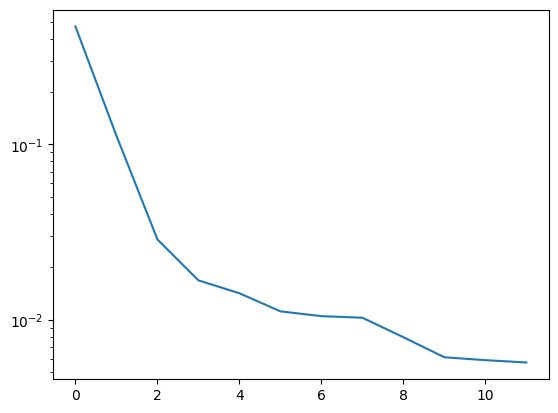

In [7]:
plt.plot(loss_list)
plt.yscale('log')
plt.show()

In [ ]:
print({stop})

NameError: name 'stop' is not defined

In [8]:
np.savetxt(data_dir+"/generation_time_gpt.dat", generation_time)
np.savetxt(data_dir+"/loss_list_gpt.dat",       loss_list)
np.savetxt(data_dir+"/neurons_gpt.dat",         neurons)
np.savetxt(data_dir+"/total_time_gpt.dat",      np.array([total_time]))

np.savetxt(data_dir+"/xt_resid_gpt.dat",        xt_resid.detach().cpu().numpy())
if (sparse):
    np.savetxt(data_dir+"/X_train_all.dat", X_train_all.detach().cpu().numpy())
    np.savetxt(data_dir+"/X_all_idx.dat",   X_all_idx.cpu().numpy())
    np.savetxt(data_dir+"/X_umax_idx.dat",  X_umax_idx.cpu().numpy())
    np.savetxt(data_dir+"/X_rmax_idx.dat",  X_rmax_idx.cpu().numpy())

#np.savetxt(data_dir+"/ac_train_all.dat",    ac_train_all)
#np.savetxt(data_dir+"/ac_test.dat",         ac_test)
#np.savetxt(data_dir+"/xt_test.dat",         xt_test.cpu().numpy())

#np.savetxt(data_dir+f"/test_{ext}gpt_losses.dat", test_gpt_losses)
#np.savetxt(data_dir+f"/test_{ext}gpt_soln.dat",   test_gpt_soln)
#np.savetxt(data_dir+f"/test_{ext}gpt_time.dat",   test_gpt_time+total_time)


In [13]:
#### Test ####
# PINN losses are computed separately due to recording them negatively effecting true run times

#ac_test = np.array(np.meshgrid(Lmbda, Eps)).T.reshape(-1,2)
ac_test = np.loadtxt(data_dir + "/ac_test.dat")

print(f"{ext.upper()}GPT-PINN Testing Started")
test_gpt_time, test_gpt_soln = gpt_test(ac_test, train_out, train_out_t, train_out_xx, 
train_out_IC, fhat, train_len, IC_size, BC_size, IC_u, c_initial, epochs_gpt_test, 
lr_gpt, out_test, train_out_BC_ub, train_out_BC_lb, train_out_BC_diff, 
train_out_BC_ub_x, train_out_BC_lb_x, train_out_BC_diff_x)

test_gpt_losses = gpt_test_loss(ac_test, train_out, train_out_t, train_out_xx, 
train_out_IC, fhat, train_len, IC_size, BC_size, IC_u, c_initial, epochs_gpt_test, 
lr_gpt, out_test, train_out_BC_ub, train_out_BC_lb, train_out_BC_diff, 
train_out_BC_ub_x, train_out_BC_lb_x, train_out_BC_diff_x)
print(f"{ext.upper()}GPT-PINN Testing Ended")

GPT-PINN Testing Started
GPT-PINN Testing Ended


In [15]:
np.savetxt(data_dir+f"/test_{ext}gpt_losses.dat", test_gpt_losses)
np.savetxt(data_dir+f"/test_{ext}gpt_soln.dat",   test_gpt_soln)
np.savetxt(data_dir+f"/test_{ext}gpt_time.dat",   test_gpt_time+total_time)

In [9]:
params = {"device":device,
          "domain": {"xi":-1, "xf":1, "ti":0, "tf":1}, 
          "data sizes": {"N_f":N_f, "N_test":xt_size, "BC_pts":BC_size, "N0":IC_size},
          "layers pinn":layers_pinn,
          "lr adam sa":lr_adam_sa,
          "lr lbfgs sa":lr_lbfgs_sa,
          "epochs adam sa":epochs_adam_sa,
          "epochs lbfgs sa":epochs_lbfgs_sa,
          "parameter size":len(ac_train_all),
          "number of neurons":number_of_neurons,
          f"lr {ext}gpt":lr_gpt,
          f"epochs {ext}gpt train":epochs_gpt_train,
          "test cases":test_cases,
          f"epochs {ext}gpt test":epochs_gpt_test,
          "sparse":sparse}
np.save(data_dir+"/params_gpt.npy", params)

In [12]:
variables = {
    "ac_test": ac_test,
    "c_initial": c_initial,
    "xt_size": xt_size,
    "IC_size": IC_size,
    "BC_size": BC_size,
    "IC_u": IC_u,
    "train_out": train_out,
    "train_out_xx": train_out_xx,
    "train_out_t": train_out_t,
    "train_out_IC": train_out_IC,
    "train_out_BC_ub": train_out_BC_ub,
    "train_out_BC_lb": train_out_BC_lb,
    "train_out_BC_ub_x": train_out_BC_ub_x,
    "train_out_BC_lb_x": train_out_BC_lb_x,
    "train_out_BC_diff": train_out_BC_diff,
    "train_out_BC_diff_x": train_out_BC_diff_x,
    "fhat": fhat,
    "epochs_gpt_test": epochs_gpt_test,
    "lr_gpt": lr_gpt,
    "neurons": neurons,
    "out_test": out_test,
}
torch.save(variables,data_dir+"/variables_gpt.npy") 